In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (19.1.1)


In [53]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from IPython.core.debugger import set_trace

In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [4]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                WITH
                    max_severity AS (
                        SELECT MAX(severity) AS severity
                        FROM (
                            SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                            GROUP BY
                                incident.blockid,
                                incident.year,
                                incident.month,
                                incident.dow,
                                incident.hour
                        ) AS categories
                    ),
                    block_incidents AS (
                        SELECT
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            incident.hour,
                            SUM(crimetype.severity)/AVG(block.population) AS severity
                        FROM incident
                        INNER JOIN block ON incident.blockid = block.id
                        INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                            AND block.population > 0
                            AND incident.cityid = 1
                            AND incident.year >= {start_year}
                            AND incident.year <= {end_year}
                        GROUP BY
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            incident.hour
                    )
                SELECT
                    block_incidents.blockid,
                    block_incidents.year,
                    block_incidents.month,
                    block_incidents.dow,
                    block_incidents.hour,
                    block_incidents.severity/max_severity.severity AS severity
                FROM block_incidents, max_severity        
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [127]:
def process_data(data, start_year, end_year, map_risk):

    NUM_BLOCKIDS = 801
    
    X = np.zeros((NUM_BLOCKIDS, 24, 7*24))
    y = np.zeros((NUM_BLOCKIDS, 12, 7*24))
    blockid_dict = {}

    # Create random array (BLOCKIDS) from 1-801 inclusive
    # of length NUM_BLOCKIDS
    BLOCKIDS = random.choices(list(range(1,802)), k=NUM_BLOCKIDS)
    
    for ind, blockid in enumerate(BLOCKIDS):
        blockid_dict[blockid] = ind

    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            if r[1] == end_year:
                # index into array  0-based month
                # vvvvvvvvvvvvvvvv    vvvvvv
                y[blockid_dict[r[0]], r[2]-1, 24*r[3]+r[4]] = map_risk(float(r[5]))
                #                             ^^^^^^^^^^^^^   ^^^^
                #                             hours since     risk
                #                             beginning of
                #                             week
            else:
                # index into array    year 0.....1   month   
                # vvvvvvvvvvvvvvvv    vvvvvvvvvvvvv  vvvvvv
                X[blockid_dict[r[0]], 12*(r[1]-start_year)+r[2]-1, 24*r[3]+r[4]] = map_risk(float(r[5]))
                #                                                  ^^^^^^^^^^^^^   ^^^^
                #                                                  hours since     risk
                #                                                  beginning of
                #                                                  week                
    
    return X, y

In [128]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year,
               testing_start_year, testing_end_year,
               map_risk):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        map_risk)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      map_risk)

    return X_train, X_test, y_train, y_test

In [129]:
def map_risk_1(risk):
    return np.power(risk * 1e5, 2)

def map_risk_0(risk):
    return risk

def map_risk_2(risk):
    return np.power(risk * 1e5, 3)

def map_risk_3(risk):
    return np.power(risk * 1e5, 4)

map_risk = [map_risk_1, map_risk_2, map_risk_3]  # , map_risk_1, map_risk_2, map_risk_3]

In [133]:
%%time
X_train, X_test, y_train, y_test = ready_data(2015, 2016, 2016, 2017, map_risk_0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(801, 24, 168) (801, 12, 168) (801, 24, 168) (801, 12, 168)
CPU times: user 2.08 s, sys: 386 ms, total: 2.47 s
Wall time: 1min 54s


In [134]:
def xgb_wrangle(data):
    flat_data = data.flatten()
    X = pd.DataFrame(data={'hour': range(len(flat_data))},
                     index=range(len(flat_data)))
    y = pd.DataFrame(data={'risk': flat_data},
                     index=range(len(flat_data)))
    return X, y

X_train_x, X_train_y = xgb_wrangle(X_train)
X_test_x, X_test_y   = xgb_wrangle(X_test)

In [135]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.7],
    'n_estimators':  [80, 100, 120],
    'max_depth': [2, 3, 4],
#     'subsample': [0.8, 0.9],
#     'colsample_bytree': [0.3, 0.4],
#     'gamma': [4, 5]
}

gridsearch = GridSearchCV(XGBRegressor(),
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=3, n_jobs=-1,
                          return_train_score=True, verbose=10)

# gridsearch.fit(train_x, train_y)
gridsearch.fit(X_train_x, X_train_y)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 10.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.7], 'n_estimators': [80, 100, 120], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=10)

In [136]:
print('  Best training score from grid search:', -gridsearch.score(X_train_x, X_train_y))
print('  Best testing score from grid search: ', -gridsearch.score(X_test_x, X_test_y))
print('Best Grid Search model:')
gridsearch.cv_results_['params'][gridsearch.best_index_]

  Best training score from grid search: 4.0663041569045364e-08
  Best testing score from grid search:  1.0134174073438722e-08
Best Grid Search model:


{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 80}

In [137]:
y_pred = gridsearch.predict(X_test_x)
print('MSE:', mean_squared_error(X_test_y, y_pred))

MSE: 1.0134174073438722e-08


In [138]:
def plot_output(y, y_pred, dataset_type):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel('Hour since beginning of data', fontsize=16)
    plt.ylabel('Risk', fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

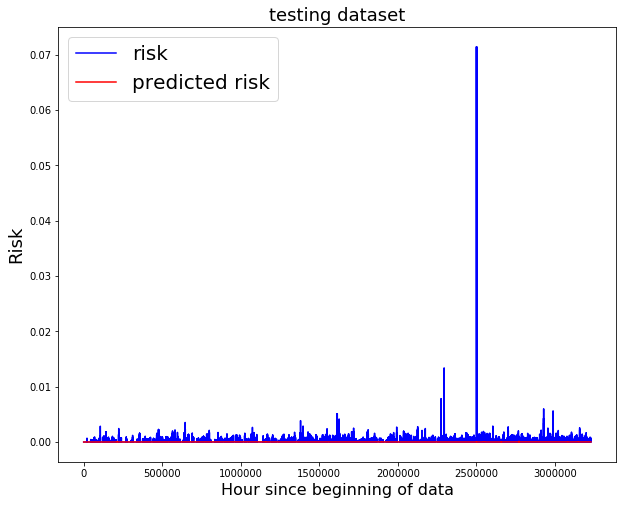

In [139]:
plot_output(X_test_y.values, y_pred, 'testing')